<a href="https://colab.research.google.com/github/nazarb/2024_JAS_qanats/blob/main/2024_JAS_qanats_demo_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

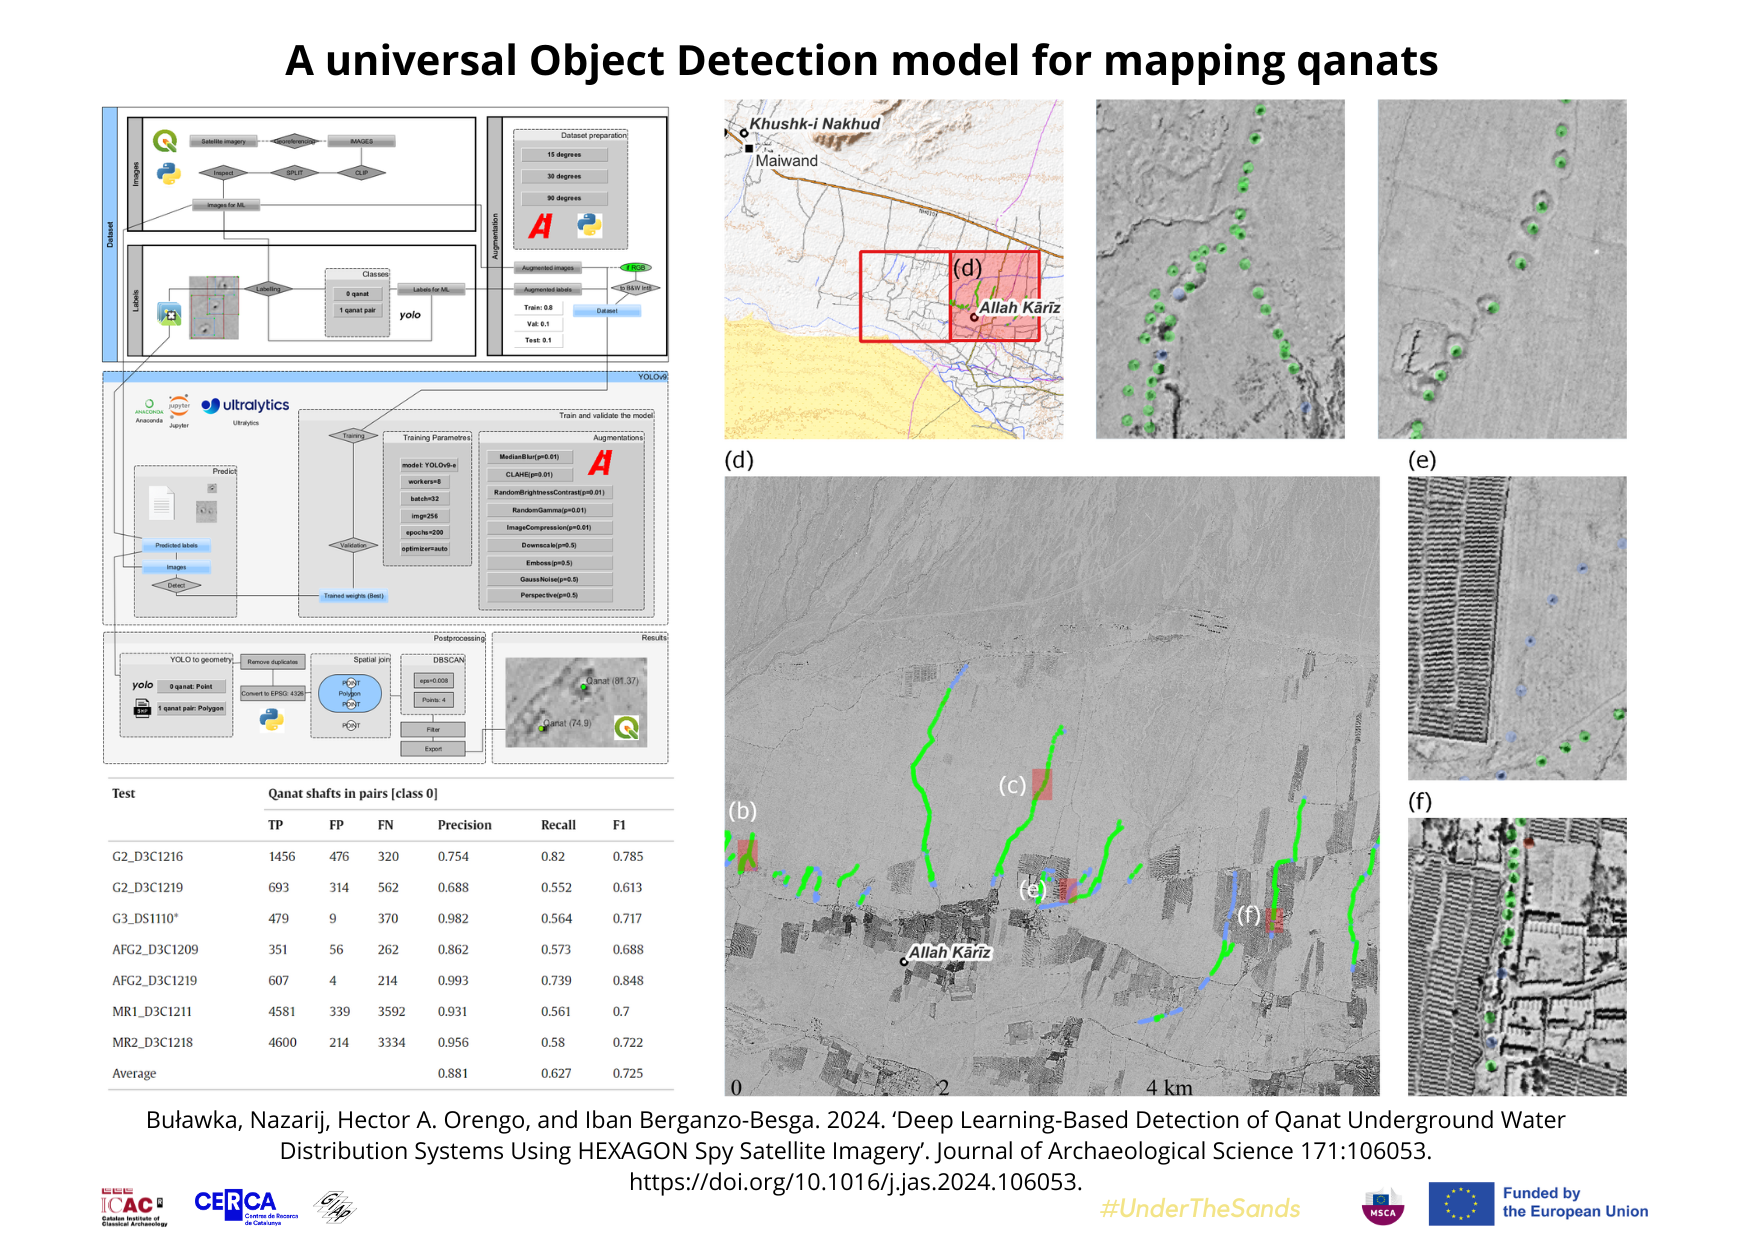


The notebook contains the workflow for detection of qanats using YOLOv9 model (Buławka, Orengo,Berganzo-Besga 2024)

Buławka, Nazarij, Hector A. Orengo, and Iban Berganzo-Besga. 2024. ‘Deep Learning-Based Detection of Qanat Underground Water Distribut ion Systems Using HEXAGON Spy Satellite Imagery’. Journal of Archaeological Science 171:106053. https://doi.org/10.1016/j.jas.2024.106053.



A selected test area located in Afghanistan using D3C1219 images is analysed to show the perfpormance of the model and entire workflow.

Table of content:
1. Initialisation and installing packages
2. Download the model and test data
3. Detect qanats using YOLOv9 model
4. Post-processing (4a. Convert YOLO labels to spatial data; 4b. Remove isolated false detections; 4c. Compare results to the reference data)
5. Visualize the results










```
# Tiene formato de código
```

***1. Initialisation and installing packages***

Google Drive will ask you for access to use GPU

In [ ]:
!git clone https://github.com/nazarb/2024_JAS_qanats.git
!pwd
%cd '/content/2024_JAS_qanats/yolov9'
!pip install --upgrade git+https://github.com/ultralytics/thop

!pip install -r requirements.txt
!pip install fiona
!sudo apt install megatools
%pip install "leafmap[raster]"
!pip install rasterio
!pip install torch==2.3.0+cu121 torchvision==0.18.0+cu121 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121

import logging
logging.getLogger().setLevel(logging.CRITICAL)
import os
import zipfile


Check GPU availability

In [ ]:

import torch
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

***2. Download the model and test data***




The following code will download, unpack and move nessary files: model and test data


In [ ]:
%cd /content/2024_JAS_qanats/yolov9/runs/train/exp/weights
!megadl 'https://mega.nz/file/Bx4BCCjY#2CqCR9N6TA8MOTi5ow3gsDSTQZSvaYa2VRJB4BQbMvU'
%cd /content/2024_JAS_qanats/datasets
!megadl 'https://mega.nz/file/5lR2HaJK#wVe9CacbQyIRjpwtTyHNDeD2lGqdVNmdxcrGam50ua0'
import zipfile
zip_ref = zipfile.ZipFile("/content/2024_JAS_qanats/datasets/BulawkaOrengoBerganzoBesga_JAS_2024_data.zip", 'r')
zip_ref.extractall("/content/2024_JAS_qanats/datasets")
zip_ref.close()
!rm -rf /content/2024_JAS_qanats/datasets/BulawkaOrengoBerganzoBesga_JAS_2024_data.zip
%cd /content/2024_JAS_qanats/yolov9/
!pwd

**3. Detect qanats using YOLOv9 model (Buławka, Orengo and Berganzo-Besga 2024)**

In [ ]:
!python detect_dual.py --weights /content/2024_JAS_qanats/yolov9/runs/train/exp/weights/BulawkaOrengoBerganzoBesga_JAS_2024_qanats_best.pt --conf 0.1 --source /content/2024_JAS_qanats/datasets/AFG2_D3C1219-split/ --img 256 --save-txt --save-conf --max-det 9999999999 --device 0

**4. Post-processing**

**4a. Convert to spatial data**

In [ ]:
%cd /content/2024_JAS_qanats/yolov9/runs/detect/exp

In [ ]:
import os
import cv2
import csv
import sys
import math
import glob
import math
import shutil
import random
import numpy as np
import skimage.io
from PIL import Image
from PIL import ImageDraw
from datetime import datetime
import rasterio
import geopandas as gpd
import pandas as pd
import fiona
from fiona.crs import from_epsg
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
import csv
from shapely.geometry import Polygon, Point, mapping
import tensorflow as tf
from tensorflow import keras

from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

input_folder = os.path.abspath(os.getcwd()) + '/labels'  # folder that includes .txt files
output_folder = os.path.abspath(os.getcwd()) + '/results'  # output folder that includes new format shp files



path=os.path.abspath(os.getcwd())

# Get Image dimensions and name
def get_image_info(image_path):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            image_name_with_extension = os.path.basename(image_path)
            image_name, _ = os.path.splitext(image_name_with_extension)
            return image_name, width, height
    except FileNotFoundError:
        print("File not found.")
    except Exception as e:
        print("Error:", e)

if __name__ == "__main__":
    image_path_ = '/content/2024_JAS_qanats/datasets/AFG2_D3C1219-merged.tif'
                # Strip quotation marks if present
    image_path = image_path_.strip('"')

    rasterName_ = os.path.splitext(os.path.basename(image_path))[0]
    rasterName = rasterName_.split('/')[-1]
    print(rasterName)

    EPSG_input = 32642
    EPSG = EPSG_input if EPSG_input else "4326"

    tesela_input = 256
    tesela = int(tesela_input) if tesela_input else 256

    print("EPSG:", EPSG)
    print("Tesela size:", tesela)

    image_name, width, height = get_image_info(image_path)
    if width and height:
        print(f"Image name: {image_name}")
        print(f"Image dimensions: {width}x{height} pixels")

# Create Points Shapefile

numShp = 1

pathDataLabels=os.path.join(path,'labels')
for filenameL in glob.glob("labels/.*"):
  os.remove(filenameL)
file_listL=os.listdir(pathDataLabels)
file_listL=sorted(file_listL)

if not os.path.exists('results'):
  os.mkdir('results')
else:
  shutil.rmtree('results')
  os.mkdir('results')

iL1 = 0
resultsLabels = np.zeros((100000, 7))
resultsLabels = resultsLabels.astype(int)
for iL in range(0,len(file_listL), 1):
	[imNameL,imExtL] = os.path.splitext("%s" %file_listL[iL])
	data = np.loadtxt("labels/%s" %file_listL[iL])
	for iL0 in range(0, len(data), 1):
		resultsLabels[iL1+iL0,0] = int(imNameL) # crop image number

		if len(data.shape) == 1:
			resultsLabels[iL1+iL0,1] = int(data[0]) # object class
			resultsLabels[iL1+iL0,3] = data[1] * tesela # x coord
			resultsLabels[iL1+iL0,4] = data[2] * tesela # y coord
			resultsLabels[iL1+iL0,5] = data[3] * tesela # x dim
			resultsLabels[iL1+iL0,6] = data[4] * tesela # y dim
			resultsLabels[iL1+iL0,2] = data[5] * 100 # similarity value
		else:
			resultsLabels[iL1+iL0,1] = int(data[iL0][0]) # object class
			resultsLabels[iL1+iL0,3] = data[iL0][1] * tesela # x coord
			resultsLabels[iL1+iL0,4] = data[iL0][2] * tesela # y coord
			resultsLabels[iL1+iL0,5] = data[iL0][3] * tesela # x dim
			resultsLabels[iL1+iL0,6] = data[iL0][4] * tesela # y dim
			resultsLabels[iL1+iL0,2] = data[iL0][5] * 100 # similarity value
	iL1 = iL1+iL0

for iD in range(0, len(resultsLabels)-iL1-1, 1):
	resultsLabels = np.delete(resultsLabels, iL1, 0)
resultsLabels = np.delete(resultsLabels, -1, 0)
np.savetxt('results/%s.txt' %rasterName, resultsLabels, fmt='%i', delimiter=' ', newline='\n')

pathDataResults=os.path.join(path,'results')
for filenameR in glob.glob("results/.*"):
  os.remove(filenameR)
file_listR=os.listdir(pathDataResults)
file_listR=sorted(file_listR)


for iF in range(0,len(file_listR), 1):
	[imName,imExt] = os.path.splitext("%s" %file_listR[iF])
	mylines = []; mylinesNumbers=[]; i2=0; i3=0; i5=-1; zeroPos=0; zeroPos2=0;# Declare an empty list named mylines.
	with open ('results/%s.txt' %imName, 'rt') as myfile: # Open txt file for reading text data.
	    for myline in myfile:                # For each line, stored as myline,
	        mylines.append(myline)           # add its contents to mylines.

	numMax = 0
	for i3 in range(0, len(mylines), 1):
	  numMax = max(numMax, len(mylines[i3]))

	for i2 in range(0, len(mylines), 1):
	  num = 0
	  mylinesIni=0
	  mylinesValues = np.zeros(shape=(1,numMax))
	  for i in range(0,len(mylines[i2]),1):
	    if mylines[i2][i] == ' ':
	      mylinesValues[0,num] = mylines[i2][mylinesIni:i]
	      mylinesIni = i+1
	      num = num + 1
	  mylinesValues[0,num] = mylines[i2][mylinesIni:-1]
	  mylinesValues2 = np.zeros(shape=(1,num+1))
	  mylinesValues2[0,:] = mylinesValues[0,0:num+1]

	  # Empty
	  polygons = []
	  points = []
	  class_ids = []
	  precisions = []
	  heights = []
	  widths = []
	  # Continue with Shapefile

	  datasetTIFF = rasterio.open(image_path)
	  leftCoord = datasetTIFF.bounds[0]
	  bottomCoord = datasetTIFF.bounds[1]
	  rightCoord = datasetTIFF.bounds[2]
	  topCoord = datasetTIFF.bounds[3]
	  resolTIFF_H = datasetTIFF.res[0]
	  resolTIFF_V = datasetTIFF.res[1]
	  teselaTIFF_H = tesela*resolTIFF_H
	  teselaTIFF_V = tesela*resolTIFF_V
	  numPNG = int(mylinesValues2[0,0]) + 1

	  columns=math.ceil(((rightCoord-leftCoord))/teselaTIFF_H)
	  rowT=math.ceil(numPNG/columns)
	  columnT=numPNG-(columns*(rowT-1))

	  numTumImg = int((len(mylinesValues2[0,:])-1)/6)
	  for i4 in range (0, numTumImg, 1):
	    lat_coord_georef = int(mylinesValues2[0,4+(i4*6)])*(teselaTIFF_V/tesela)
	    lat_point = (topCoord-(teselaTIFF_V*(rowT-1))-lat_coord_georef)
	    lon_coord_georef = int(mylinesValues2[0,3+(i4*6)])*(teselaTIFF_H/tesela)
	    lon_point = (leftCoord+(teselaTIFF_H*(columnT-1))+lon_coord_georef)
	    height_ = int(mylinesValues2[0,5+(i4*6)])*(teselaTIFF_V/tesela)
	    width_ = int(mylinesValues2[0,6+(i4*6)])*(teselaTIFF_V/tesela)
	    x_min = lon_point - (height_/2)
	    y_min = lat_point - (width_/2)
	    x_max = lon_point + (height_/2)
	    y_max = lat_point + (width_/2)


	    with open('results/outputPoints.csv', 'a', newline='') as file:
	        writer = csv.writer(file)

	        if numShp == 1:
	            writer.writerow(["X", "Y", "Region", "Tile", "Class", "precision", "SizeX", "SizeY", "x_min", "y_min", "x_max", "y_max"])
	        writer.writerow([float(lon_point), float(lat_point), imName, int(mylinesValues2[0,0+(i4*6)]), int(mylinesValues2[0,1+(i4*6)]), int(mylinesValues2[0,2+(i4*6)]), int(mylinesValues2[0,5+(i4*6)]), int(mylinesValues2[0,6+(i4*6)]), x_min, y_min, x_max, y_max])
	        numShp = numShp + 1

## Convert outputPoints.csv into qanat shafts and qanats pairs

# Define a function to convert x_min, y_min, x_max, y_max to a polygon
def create_polygon(x_min, y_min, x_max, y_max):
    return Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])
# Define a function to convert x_min, y_min, x_max, y_max to a polygon
def create_point(X, Y):
    return Point([(X, Y)])

from_epsg(EPSG)

# Open the CSV file and read the data
with open('results/outputPoints.csv', 'r') as file:
    reader = csv.DictReader(file)
    data = [(float(row['x_min']), float(row['y_min']), float(row['x_max']), float(row['y_max']), row['Region'], row['Class'], row['Tile'], row['precision'], row['SizeX'], row['SizeY']) for row in reader if row['Class'] == '1']
# Define schema for the shapefile
schema = {
    'geometry': 'Polygon',
    'properties': {'Region': 'str', 'Class': 'str', 'Tile': 'str', 'precision': 'float', 'SizeX': 'float', 'SizeY': 'float'},
    'crs': EPSG  # Example: EPSG code 4326 for WGS 84
}


# Create a new shapefile
with fiona.open('results/'+image_name+'_qanat_pairs.shp', 'w',crs=from_epsg(EPSG),driver='ESRI Shapefile', schema=schema) as c:
    # Iterate through the data and create polygons
    for coords in data:
        polygon = Polygon([(coords[0], coords[1]), (coords[2], coords[1]), (coords[2], coords[3]), (coords[0], coords[3])])
        c.write({
            'geometry': mapping(polygon),
            'properties': {'Region': coords[4], 'Class': coords[5], 'Tile': coords[6], 'precision': float(coords[7]), 'SizeX': float(coords[8]), 'SizeY': float(coords[9])},
        })


# Open the CSV file and read the data
with open('results/outputPoints.csv', 'r') as file:
    reader = csv.DictReader(file)
    data_p = [(float(row['X']), float(row['Y']), row['Region'], row['Class'], row['Tile'], row['precision'], row['SizeX'], row['SizeY']) for row in reader if row['Class'] == '0']

# Define schema for the shapefile including CRS
schema2 = {
    'geometry': 'Point',
    'properties': {'Region': 'str', 'Class': 'str', 'Tile': 'str', 'precision': 'float', 'SizeX': 'float', 'SizeY': 'float'},
    'crs': EPSG  # Example: EPSG code 4326 for WGS 84
}
# Create a new shapefile
with fiona.open('results/'+image_name+'_qanats.shp',  'w',crs=from_epsg(EPSG),driver='ESRI Shapefile', schema=schema2) as c:
    # Iterate through the filtered data and create points
    for coords in data_p:
        point = Point(coords[0], coords[1])
        c.write({
            'geometry': mapping(point),
            'properties': {'Region': coords[2], 'Class': coords[3], 'Tile': coords[4], 'precision': float(coords[5]), 'SizeX': float(coords[6]), 'SizeY': float(coords[7])},
        })



    # Save precision to a text file
    precision_filename = os.path.splitext(image_name)[0] + "_results" + ".txt"
    with open(precision_filename, 'w') as f:
        f.write("Date: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S") + "\n")

        f.write("Enter the path to the image file: " + str(image_path) + "\n")
        f.write("Enter EPSG number: " + str(EPSG) + "\n")
        f.write("Enter tesela size: " + str(tesela) + "\n")
        f.write("Image dimensions: "+str(width)+"x"+str(height)+" pixels")

print("Shapefile created")
print('\n')



**4b. Filter isolated false detections**


*   Convert to a WGS 1984
*   Remove duplicates
*   Calculate spatial join
*   Calculate DBSCAN
*   Perform filtering


In [ ]:
import os
import geopandas as gpd
from shapely.ops import transform
from pyproj import Transformer
import warnings

warnings.filterwarnings("ignore")

# Get the current working directory
Path = os.path.abspath(os.getcwd())
folder_path = os.path.join(Path, "results")
print("Current working directory:", folder_path)

# List all files in the folder
files = os.listdir(folder_path)

# Filter spatial feature classes
feature_classes = [file for file in files if file.endswith(('.shp', '.gpkg'))]

# Iterate over each spatial file
for spatial_file in feature_classes:
    # Read the spatial data
    spatial_data = gpd.read_file(os.path.join(folder_path, spatial_file))

    # Define transformer to convert CRS to EPSG:3857
    transformer = Transformer.from_crs(spatial_data.crs, "EPSG:4326", always_xy=True)

    # Apply transformation to geometry
    spatial_data['geometry'] = spatial_data['geometry'].apply(lambda geom: transform(transformer.transform, geom))

    spatial_data = spatial_data.drop_duplicates(subset='geometry')

    # Construct the output file path
    original_name, extension = os.path.splitext(spatial_file)
    processed_file_name = original_name + "_cl" + extension
    output_file = os.path.join(folder_path, processed_file_name)

    # Save the result in GeoPackage format
    ## spatial_data.to_file(output_file, driver='GPKG', crs="EPSG:4326") ## ensure fiona is used
    spatial_data.to_file(output_file, driver='GPKG', crs="EPSG:4326", engine="fiona")

    # Print first few rows of the processed data
    print(f"Processed file: {processed_file_name}")
    #print(spatial_data.head())
    print("Finished")


import os
import geopandas as gpd
import pandas as pd
from sklearn.cluster import DBSCAN
import warnings

warnings.filterwarnings("ignore")

# Get the current working directory
Path = os.path.abspath(os.getcwd())
folder_path = os.path.join(Path, "results")
print("Current working directory:", folder_path)

# List all files in the folder
files = os.listdir(folder_path)

# Filter spatial feature classes
feature_classes = [file for file in files if file.endswith('.shp')]

# Filter qanat pairs and qanats layers
qanat_pairs_layer = [fc for fc in feature_classes if 'qanat_pairs_cl' in fc][0]
qanats_layer = [fc for fc in feature_classes if 'qanats_cl' in fc][0]

# Read the spatial data
qanat_pairs = gpd.read_file(os.path.join(folder_path, qanat_pairs_layer))
qanats = gpd.read_file(os.path.join(folder_path, qanats_layer))

# Perform spatial join
##joined_data = gpd.sjoin(qanats, qanat_pairs, how="left", op="within") ## changed to newer version
joined_data = gpd.sjoin(qanats, qanat_pairs, how="left", predicate="within")

# Handle NaNs in index_right column
joined_data['index_right'] = pd.to_numeric(joined_data['index_right'], errors='coerce')

# Fill NaNs with appropriate values
joined_data['index_right'].fillna(-1, inplace=True)

# Cast index_right column to integers
joined_data['index_right'] = joined_data['index_right'].astype(int)

# Create a new column indicating which points are within polygons
joined_data['within_qanat_pairs'] = joined_data['index_right'] != -1

# Drop invalid geometries
joined_data = joined_data[joined_data['geometry'].is_valid]

# Extract latitude and longitude
joined_data['latitude'] = joined_data.geometry.y
joined_data['longitude'] = joined_data.geometry.x

# Filter the data to remove points with the same location
data_wd = joined_data.drop_duplicates(subset=['latitude', 'longitude'])

# Set eps based on EPSG code
if data_wd.crs.to_epsg() == 4326:
    eps = 0.0008
else:
    eps = 80
print(eps)
# Prepare data for clustering
X = data_wd[['latitude', 'longitude']]


# Perform DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=4)
clusters = dbscan.fit_predict(X)

# Add cluster labels to joined data
data_wd['cluster'] = clusters



# Filter the data further
filtered_data = data_wd[(data_wd['cluster'] != -1) &
                              (data_wd['within_qanat_pairs'] == True) &
                              (data_wd['precision_right'] >= 10) &
                              (data_wd['precision_left'] >= 10)]

# Construct the output file path
original_name, extension = os.path.splitext(qanats_layer)
processed_file_name = original_name + "_processed0008.gpkg"
output_file = os.path.join(folder_path, processed_file_name)

# Save the result in GeoPackage format

## filtered_data.to_file(output_file, driver='GPKG', crs="EPSG:4326") ## ensure fiona
filtered_data.to_file(output_file, driver='GPKG', crs="EPSG:4326", engine="fiona")

# Print first few rows of the joined data
#print(filtered_data.head())
print(os.path.join(folder_path, processed_file_name))


**4c. Compare to reference data**


*   Perform spatial joins
*   Count points
*   Calculate Precision, Recall and F1-score


In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import os
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
folder_path = os.path.abspath(os.getcwd())
print("Current working directory:", folder_path)

# Assign functions
# Part 1: Create buffers around detected features and reference data
def create_buffers(input_fc, output_fc, distance):
    gdf = gpd.read_file(input_fc)
    # gdf = gdf.to_crs("EPSG:3857")  # Project to a suitable projected CRS
    gdf['geometry'] = gdf.geometry.buffer(distance)
    # gdf = gdf.to_crs("EPSG:4326")  # Convert back to original CRS
    gdf.to_file(output_fc)
# Part 2: Spatial join A with B_buff
def spatial_join_A_with_B(A_fc, B_buff_fc, output_fc):
    A_gdf = gpd.read_file(A_fc)
    B_buff_gdf = gpd.read_file(B_buff_fc)
    ## joined = gpd.sjoin(A_gdf, B_buff_gdf, how='left', op='intersects', lsuffix='dat_', rsuffix='ref_') ## changed to newer version
    joined = gpd.sjoin(A_gdf, B_buff_gdf, how='left', predicate='intersects', lsuffix='dat_', rsuffix='ref_')
    joined['FN'] = None  # Set FN attribute to Null
    joined['TP'] = joined['index_ref_'].apply(lambda x: 1 if not pd.isnull(x) else 0)
    joined.to_file(output_fc)
# Part 3: Spatial join B with A_buff
def spatial_join_B_with_A(B_fc, A_buff_fc, output_fc):
    B_gdf = gpd.read_file(B_fc)
    A_buff_gdf = gpd.read_file(A_buff_fc)
    ## joined = gpd.sjoin(B_gdf, A_buff_gdf, how='left', op='intersects', lsuffix='ref_', rsuffix='dat_') ## changed to newer version
    joined = gpd.sjoin(B_gdf, A_buff_gdf, how='left', predicate='intersects', lsuffix='ref_', rsuffix='dat_') ## changed to newer version
    joined['FN'] = 1  # Set FN attribute to 1 for points with no intersection
    no_intersection = joined[pd.isnull(joined['index_dat_'])]
    no_intersection.to_file(output_fc)


# Main function
def main():
    A_fc_ = '/content/2024_JAS_qanats/yolov9/runs/detect/exp/results/AFG2_D3C1219-merged_qanats_cl_processed0008.gpkg'
    A_fc = A_fc_.strip('"')
    B_fc_ = '/content/2024_JAS_qanats/datasets/AFG2_D3C1219-reference.gpkg'
    B_fc = B_fc_.strip('"')
    distance = 0.00004

    # Part 1
    create_buffers(A_fc, 'A_buff.gpkg', distance)
    create_buffers(B_fc, 'B_buff.gpkg', distance)

    # Part 2
    spatial_join_A_with_B(A_fc, 'B_buff.gpkg', 'part2_output.gpkg')

    # Part 3
    spatial_join_B_with_A(B_fc, 'A_buff.gpkg', 'part3_output.gpkg')

    # Merge part 2 and part 3 outputs
    part2_output = gpd.read_file('part2_output.gpkg')
    part3_output = gpd.read_file('part3_output.gpkg')
    merged_output = gpd.GeoDataFrame(pd.concat([part2_output, part3_output], ignore_index=True), crs=part2_output.crs)
    merged_output['_X'] = merged_output.geometry.x
    merged_output['_Y'] = merged_output.geometry.y
    merged_output.drop_duplicates(subset=['_X', '_Y'], inplace=True)  # Remove duplicates based on X and Y coordinates
    merged_output.drop(columns=['_X', '_Y'], inplace=True)
    merged_output.drop(columns=['latitude', 'longitude'], inplace=True)
    merged_output['longitude'] = merged_output.geometry.x
    merged_output['latitude'] = merged_output.geometry.y

    output_filename = os.path.splitext(os.path.basename(A_fc))[0] + "_TP_FP_FN.gpkg"
    merged_output.to_file(output_filename)
    merged_output.head()

    resultsm = qanat_pairs = gpd.read_file(os.path.join(folder_path, output_filename))


        # Count points in groups
    tp_count = resultsm[resultsm['TP'] == 1].shape[0]
    fp_count = resultsm[resultsm['TP'] == 0].shape[0]
    fn_count = resultsm[resultsm['FN'] == "1"].shape[0]
    recall = tp_count / (tp_count + fn_count)
    recall = round(recall, 3)

    precision = tp_count / (tp_count + fp_count)
    precision = round(precision, 3)
    f_1 = (2 * tp_count) / ((2 * tp_count)+fp_count+fn_count)
    f_1 = round(f_1, 3)

    print("TP count:", tp_count)
    print("FP count:", fp_count)
    print("FN count:", fn_count)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f_1)
    print("Detection of qanats in the AFG2 area using D3C1219 images complete.")
    print("Compare the results with the table below (line: AFG2_D3C1219)")

    # Save precision to a text file
    precision_filename = os.path.splitext(output_filename)[0] + ".txt"
    with open(precision_filename, 'w') as f:
        f.write("Date: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S") + "\n")

        f.write("Detected features: " + str(A_fc) + "\n")

        f.write("Reference features: " + str(B_fc) + "\n")
        f.write("TP count:" + str(tp_count) + "\n")
        f.write("FP count:" + str(fp_count) + "\n")
        f.write("FN count:" + str(fn_count) + "\n")

        f.write("Precision: " + str(precision) + "\n")

        f.write("Recall: " + str(recall) + "\n" )

        f.write("F1 score: " + str(f_1) + "\n" )

        f.write(str(tp_count) + "	" + str(fp_count) + "	" + str(fn_count) + "	" + str(precision) + "	" +  str(recall) + "	" + str(f_1) +"\n" )


    # Remove temporary files
    files_to_remove = ["part2_output.gpkg", "part3_output.gpkg", "B_buff.gpkg", "A_buff.gpkg"]

    for file_name in files_to_remove:
        if os.path.exists(file_name):
            os.remove(file_name)
            #print(f"Removed {file_name}")
        #else:
            #print(f"{file_name} does not exist.")


if __name__ == "__main__":
    main()


The results should fit the following table (or be slightly better)



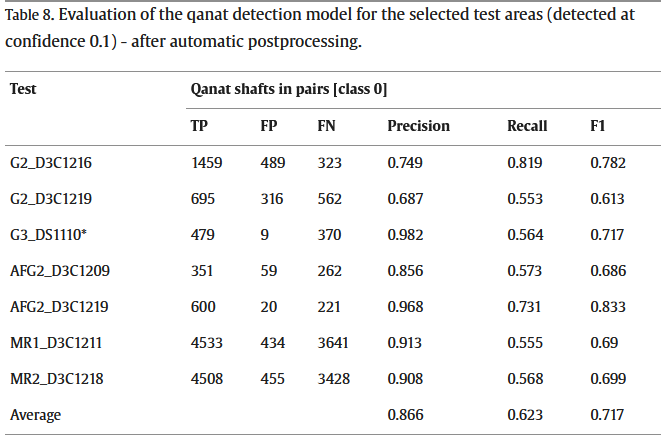

**5. Visualize the results**

In [ ]:
import leafmap
import geopandas as gpd

latitude = 31.52806
longitude = 65.24722

# Load the map
m = leafmap.Map(center=[latitude, longitude], zoom=24)

# Add the raster layer
m.add_raster("/content/2024_JAS_qanats/datasets/AFG2_D3C1219-merged.tif", layer_name="AFG2_D3C1219")

# Load the GeoPackage file
qanats = "/content/2024_JAS_qanats/yolov9/runs/detect/exp/AFG2_D3C1219-merged_qanats_cl_processed0008_TP_FP_FN.gpkg"
gdf = gpd.read_file(qanats)

# Check the CRS and transform to lat/lon (EPSG:4326) if needed
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Extract coordinates (latitude, longitude) from the geometry
gdf["longitude"] = gdf.geometry.x
gdf["latitude"] = gdf.geometry.y

# Create separate GeoDataFrames for TP, FP, and FN
gdf_tp = gdf[gdf['TP'] == 1]  # True Positives
gdf_fp = gdf[gdf['TP'] == 0]  # False Positives
gdf_fn = gdf[gdf['FN'] == '1']  # False Negatives

# Add circle markers to the map
m.add_circle_markers_from_xy(
    gdf_tp, x="longitude", y="latitude", radius=3, color="#0dff0d", fill_color="#0dff0d", layer_name="True Positives", stroke=False, fill_opacity=0.5
)
m.add_circle_markers_from_xy(
    gdf_fp, x="longitude", y="latitude", radius=3, color="#e5350e", fill_color="#e5350e", layer_name="False Positives", stroke=False, fill_opacity=0.5
)
m.add_circle_markers_from_xy(
    gdf_fn, x="longitude", y="latitude", radius=3, color="#729bff", fill_color="#729bff", layer_name="False Negatives", stroke=False, fill_opacity=0.5
)

# Add a legend to the map
legend_dict = {
    "True Positives": "#0dff0d",
    "False Positives": "#e5350e",
    "False Negatives": "#729bff"
}
m.add_legend(title="Detection Results", legend_dict=legend_dict)

# Add a layer control for toggling layers
m.add_layer_control()

# Display the map
m
